In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [58]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [6]:
dataset = datasets.ImageFolder(root="data", transform=transform)

Text(0.5, 1.0, 'Primeira imagem')

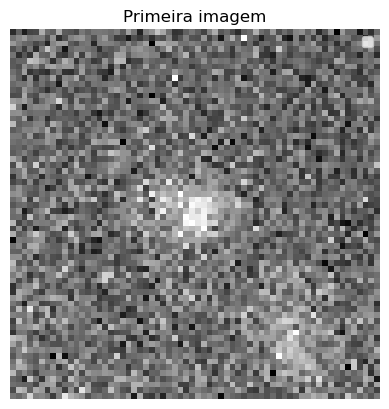

In [7]:
img, label = dataset[0]

plt.imshow(img.squeeze(0), cmap='gray')
plt.legend(f"{dataset.classes[label]}")
plt.axis('off')
plt.title('Primeira imagem')

Text(0.5, 1.0, 'Última imagem')

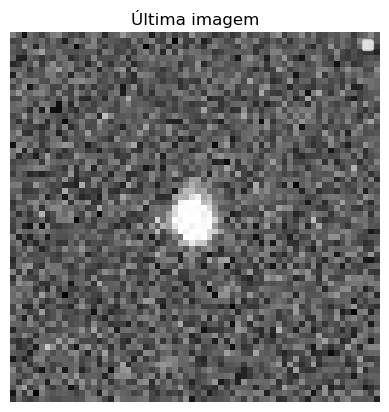

In [8]:
img, label = dataset[-1]

plt.imshow(img.squeeze(0), cmap='gray')
plt.legend(f"{dataset.classes[label]}")
plt.axis('off')
plt.title('Última imagem')

In [9]:
dataloader_noNorm = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

In [10]:
total_sum = torch.zeros(1)
total_sqsum = torch.zeros(1)
total_pixels = 0

with torch.no_grad():
    for images, labels in dataloader_noNorm:
        b = images.shape[0]
        c = images.shape[1]
        h = images.shape[2]
        w = images.shape[3]

        sum_batch = torch.sum(images, dim=(0, 2, 3))
        sqsum_batch = torch.sum(images**2, dim=(0, 2, 3))
        pixels_batch = b * h * w

        total_sum += sum_batch
        total_sqsum += sqsum_batch
        total_pixels += pixels_batch

In [11]:
mean = total_sum / total_pixels
var = total_sqsum / total_pixels - mean**2
std = torch.sqrt(var)

print(f"Média: {mean.item():.6f}\nDesvio padrão: {std.item():.6f}\nTotal de pixels: {total_pixels:,}")

Média: 0.357345
Desvio padrão: 0.145830
Total de pixels: 16,322,560


In [12]:
m = mean.item()
s = std.item()

print(f"m = {m:.6f}\ns = {s:.6f}")

m = 0.357345
s = 0.145830


In [13]:
train_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s]),
])

In [14]:
val_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s])
])

In [15]:
train_dataset = datasets.ImageFolder(root='data', transform=train_transform)

In [16]:
totalsize = len(train_dataset)
train_size = int(0.7 * totalsize)
validate_size = int(0.15 * totalsize)
test_size = totalsize - train_size - validate_size

In [17]:
train_df, validate_df, test_df = random_split(
    train_dataset,[train_size, validate_size, test_size], 
    torch.Generator().manual_seed(42)
    )

In [18]:
train_loader = DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)
validate_loader = DataLoader(validate_df, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_df, batch_size=32, shuffle=False, num_workers=4)

In [19]:
print(f"Total: {len(train_df + validate_df + test_df)}, Train: {len(train_df)}, Validation: {len(validate_df)}, Test: {len(test_df)}")

Total: 3985, Train: 2789, Validation: 597, Test: 599


In [20]:
torch.manual_seed(42)
it_loader = iter(train_loader)

with torch.no_grad():
    images, labels = next(it_loader)
    mean_batch = images.mean(dim=(0, 2, 3))
    std_batch = images.std(dim=(0, 2, 3))

    print(f"Média do batch: {mean_batch.item():.4f}\nDesvio padrão do batch: {std_batch.item():.5f}\nIdeal: ~0.0 e ~1.0")
    

Média do batch: 0.0726
Desvio padrão do batch: 1.06962
Ideal: ~0.0 e ~1.0


In [21]:
min_val = images.min().item()
max_val = images.max().item()

print(f"Valores pós normalização \nMínimo: {min_val:.6f}\nMáximo: {max_val:.6f}")

Valores pós normalização 
Mínimo: -2.450424
Máximo: 4.406888


In [22]:
train_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomResizedCrop(size=(128, 128), scale=(0.9, 1.0), ratio=(0.98, 1.02)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s])
])

In [23]:
class CNN(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.5):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.adaptive_pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [24]:
model = CNN(num_classes=1, dropout_rate=0.5).to(device)

dummy = torch.randn(1, 1, 128, 128).to(device)
out = model(dummy)

num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Output: {out.shape}\nParâmetros: {sum(p.numel() for p in model.parameters()):,}")

Output: torch.Size([1, 1])
Parâmetros: 2,552,257


In [ ]:
learning_rate = 0.0001

weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)


In [26]:
num_epochs = 10
epoch_loss, epoch_accuracy = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.float().unsqueeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = (outputs > 0).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_loss.append(avg_loss)
    epoch_accuracy.append(epoch_acc)
    print(f"Geração [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} Acurácia: {epoch_acc:.2f}%")

Geração [1/10] Loss: 0.5444 Acurácia: 75.65%
Geração [2/10] Loss: 0.4539 Acurácia: 78.02%
Geração [3/10] Loss: 0.3452 Acurácia: 84.62%
Geração [4/10] Loss: 0.2670 Acurácia: 88.96%
Geração [5/10] Loss: 0.1892 Acurácia: 92.65%
Geração [6/10] Loss: 0.1412 Acurácia: 94.94%
Geração [7/10] Loss: 0.0762 Acurácia: 98.10%
Geração [8/10] Loss: 0.0604 Acurácia: 98.24%
Geração [9/10] Loss: 0.0225 Acurácia: 99.61%
Geração [10/10] Loss: 0.0112 Acurácia: 99.89%


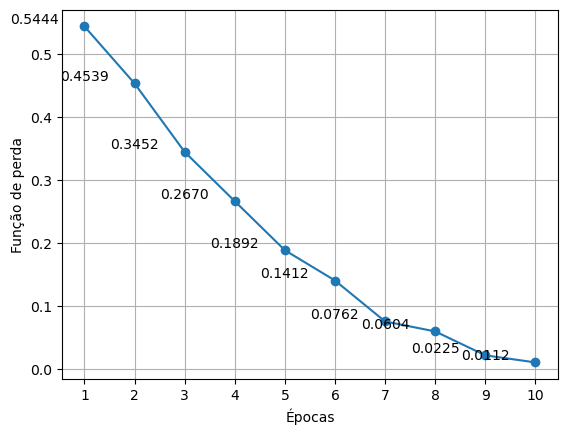

In [53]:
x = range(1, len(epoch_loss) + 1)

plt.plot(x, epoch_loss, marker = 'o')
plt.xlabel("Épocas")
plt.ylabel("Função de perda")
plt.grid()

y = epoch_loss

for i, valor in enumerate(epoch_loss):
    plt.text(i, valor, f'{valor:.4f}', ha='center', va='bottom')
    
plt.xticks(range(1, 11))
plt.show()

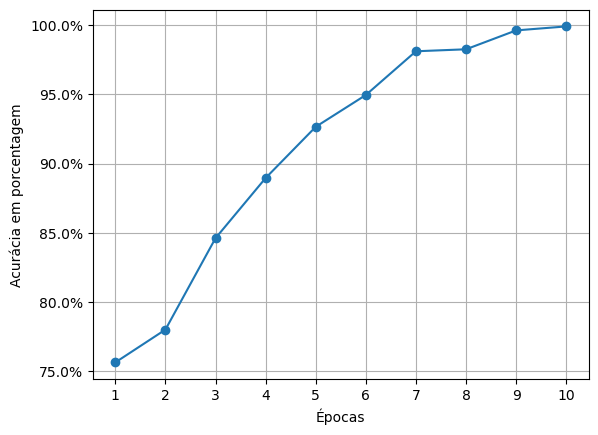

In [59]:
x = range(1, len(epoch_accuracy) + 1)

plt.plot(x, epoch_accuracy, marker = 'o')
plt.xlabel("Épocas")
plt.ylabel("Acurácia em porcentagem")
plt.grid()

plt.gca().yaxis.set_major_formatter(PercentFormatter())
    
plt.xticks(range(1, 11))
plt.show()